# Sample MNIST <-> EMNIST

In [1]:
import torch as th
import torchvision.utils as tu
from torch.utils.data import Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from utils import EMAHelper, load_state_dict, euler_discretization, draw_square
from models.transformer import OperatorTransformer

In [2]:
ckpt_path = './checkpoint/mnist_300000.npz'

In [21]:
th.manual_seed(42)
np.random.seed(42)

device = th.device("cuda:0")
checkpoint = th.load(ckpt_path, map_location=device)

In [22]:
def init_nn():
    return OperatorTransformer(
        in_channel = 2,
        out_channel = 1,
        latent_dim = 256,
        pos_dim = 256,
        num_heads = 4,
        depth_enc = 6,
        depth_dec = 2,
        scale = 1,
        self_per_cross_attn = 1,
        height=64
    )

def load_model(checkpoint, device):
    fwd_nn = init_nn().to(device)
    bwd_nn = init_nn().to(device)
    
    ema_decay=0.999
    fwd_ema = EMAHelper(fwd_nn, ema_decay, device)
    bwd_ema = EMAHelper(bwd_nn, ema_decay, device)
    
    saves = [bwd_nn, bwd_ema, fwd_nn, fwd_ema]
    ckpt_keys = ['bwd_nn', 'bwd_ema', 'fwd_nn', 'fwd_ema']

    load_state_dict(checkpoint, saves, ckpt_keys)
    fwd_sample_nn = fwd_ema.ema_copy()
    bwd_sample_nn = bwd_ema.ema_copy()
    
    return fwd_sample_nn, bwd_sample_nn

fwd_sample_nn, bwd_sample_nn = load_model(checkpoint, device)
print('Model loaded')

Model loaded


In [23]:
discretization_steps = 100
dt = 1.0 / discretization_steps
sigma = 1.0

direction = "fwd" # MNIST -> EMNIST
direction = "bwd" # EMNIST -> MNIST

if direction == "fwd":
    source = "mnist"
    target = "emnist"
    model = fwd_sample_nn.eval()
else:
    source = "emnist"
    target = "mnist"
    model = bwd_sample_nn.eval()

In [24]:
class EMNIST(datasets.EMNIST):
    def __init__(self, **kwargs):
        super().__init__(split="letters", **kwargs)
        indices = (self.targets <= 5).nonzero(as_tuple=True)[0]
        self.data, self.targets = (
            self.data[indices].transpose(1, 2),
            self.targets[indices],
        )
def init_transform(res):
    return transforms.Compose([
            transforms.Pad(2,fill=0),
            transforms.Resize([res , res]),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
transform = init_transform(32)

DATA_DIR = './data'
if source == "mnist":
    data_src = datasets.MNIST(root=DATA_DIR, train=False, download=True)
else:
    data_src = EMNIST(root=DATA_DIR, train=False, download=True)

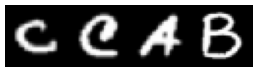

In [25]:
if source == 'mnist':
    sample_ids = [2983, 3823, 2051, 3895] # MNIST -> EMNIST
else:
    sample_ids = [2065, 1766, 315, 1455] # EMNIST -> MNIST

transform = init_transform(32)
images = th.stack([transform(data_src[i][0]) for i in sample_ids], dim=0)

def show_image(images, ncol=4, padding=0):
    images = th.clip((images + 1.0) / 2.0, 0.0, 1.0)
    img_size = images.shape[-1]
    tv_images = tu.make_grid(images, nrow=ncol, padding=padding, pad_value=1.0)
    plt.figure(dpi=int(100*(img_size/64)))
    plt.imshow(tv_images.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_image(images, ncol=4)

Sampling resolution: 32x32
Sampling resolution: 64x64
Sampling resolution: 128x128


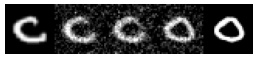

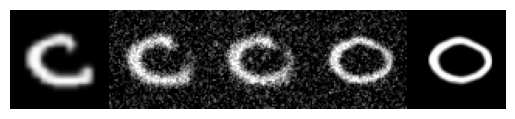

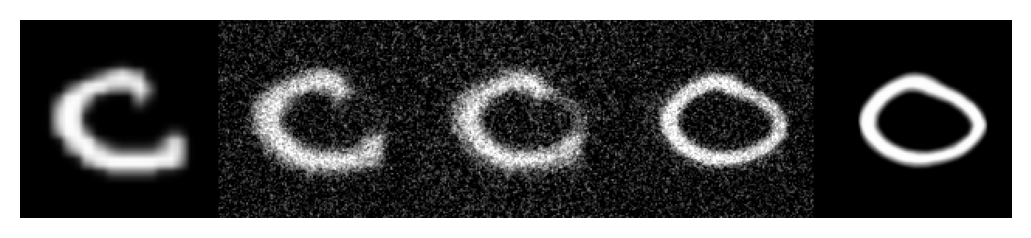

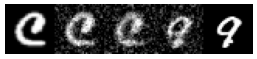

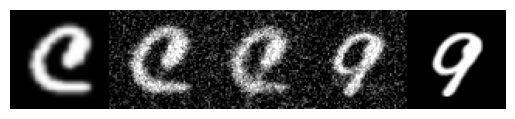

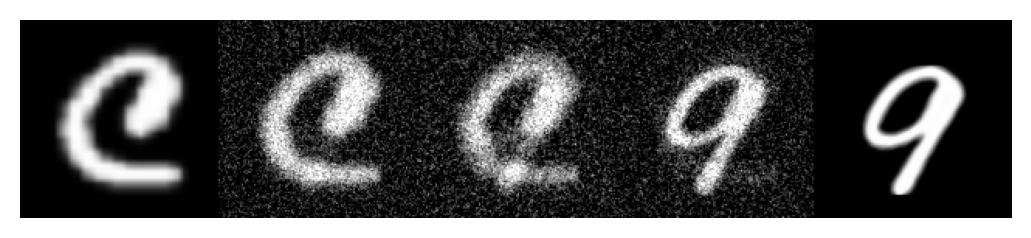

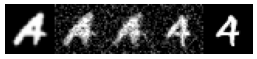

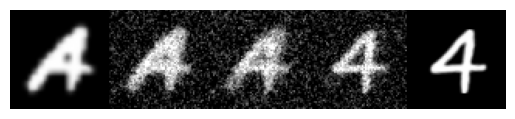

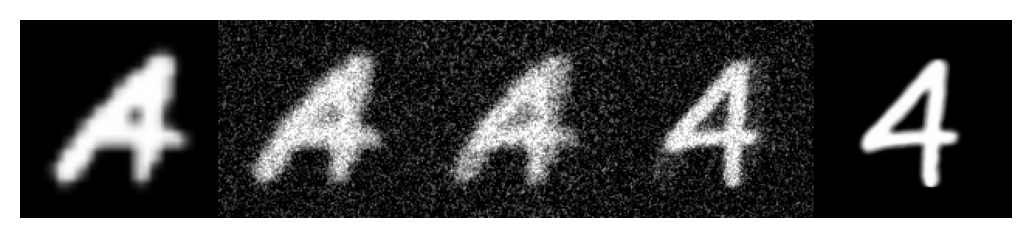

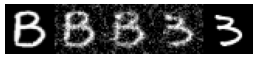

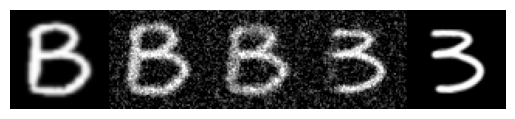

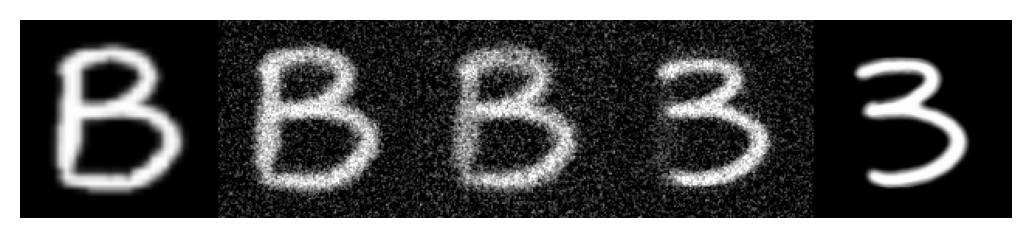

In [26]:
resolutions = [32, 64, 128]
batch_sizes = [16, 4, 2]

results = []
for res in resolutions:
    print(f"Sampling resolution: {res}x{res}")
    transform = init_transform(res)
    batch_dim = batch_sizes[resolutions.index(res)]
    batch_dim = max(1, min(batch_dim, len(sample_ids)))

    xts_list = []    
    for b_i in range(int(np.ceil(len(sample_ids) / batch_dim))):
        # Load the images and preprocess
        input_ids = sample_ids[b_i * batch_dim: (b_i + 1) * batch_dim]
        images = th.stack([transform(data_src[i][0]) for i in input_ids], dim=0).to(device)
        
        # Initialize the path
        s_path = th.zeros(size=(discretization_steps + 1,) + (batch_dim, 1, res, res), device=device)
        p_path = th.zeros(size=(discretization_steps,) + (batch_dim, 1, res, res), device=device)
        s_path[0] = images

        # Sampling images
        with th.no_grad():
            euler_discretization(s_path, p_path, model, sigma, device)
            
        xts_list.append(s_path.cpu())
    xts = th.cat(xts_list, dim=1)
    results.append(xts)

# Display sampled images
for i in range(len(sample_ids)):
    for j in range(len(resolutions)):
        summary_index = [0, 20, 40, 80, -1]
        show_image(results[j][summary_index, i], ncol=5)
        

# Generate GIF samples

In [19]:
resolutions = [32, 64, 128]
batch_sizes = [16, 4, 2]

results = []
for res in resolutions:
    print(f"Sampling resolution: {res}x{res}")
    transform = init_transform(res)
    batch_dim = batch_sizes[resolutions.index(res)]

    if res == 32:
        if source == 'mnist':
            sample_ids = [3754, 3851, 1561, 2999, 2982, 878, 954, 2446, 
                          2368, 1633, 3141, 682, 864, 973, 1942, 1602, 
                          510, 3788, 3547, 2924, 1681, 850, 2863, 29, 
                          1708, 3591, 1748, 2142, 1458, 146, 2443, 1589, 
                          1818, 2403, 1855, 2492, 297, 976, 125, 1936, 
                          3692, 3578, 1109, 421, 3287, 3030, 552, 987, 
                          1471, 443, 119, 361, 2663, 1198, 2983, 3823, 
                          1869, 223, 1005, 3052, 3386, 132, 2051, 3895,]
        else:
            sample_ids = [685,140,633,1233,1076,1966,1517,2853,
                          781,1359,1538,853,780,46,630,2860,
                          2636,2760,2000,3059,976,2094,2395,96,
                          2536,2666,2693,708,237,5,396,1728,
                          1424,1420,1039,2697,2381,2952,2865,1839,
                          1641,1248,1750,446,730,134,561,1277,
                          2122,1320,2003,1205,2946,1355,2065,1766,
                          892,649,2014,1869,1025,171,315,1455,]
    elif res == 64:
        if source == 'mnist':
            sample_ids = [297, 976, 125, 1936, 
                          3287, 3030, 552, 987, 
                          2663, 1198, 2983, 3823, 
                          3386, 132, 2051, 3895,]
        else:
            sample_ids = [2381,2952,2865,1839,
                          730,134,561,1277,
                          2946,1355,2065,1766,
                          1025,171,315,1455,]
    elif res == 128:
        if source == 'mnist':
            sample_ids = [2983, 3823, 
                          2051, 3895,]
        else:
            sample_ids = [2065, 1766, 
                          315, 1455,]

    batch_dim = max(1, min(batch_dim, len(sample_ids)))
    xts_list = []    
    for b_i in range(int(np.ceil(len(sample_ids) / batch_dim))):
        # Load the images and preprocess
        input_ids = sample_ids[b_i * batch_dim: (b_i + 1) * batch_dim]
        images = th.stack([transform(data_src[i][0]) for i in input_ids], dim=0).to(device)

        # Initialize the path
        s_path = th.zeros(size=(discretization_steps + 1,) + (batch_dim, 1, res, res), device=device)
        p_path = th.zeros(size=(discretization_steps,) + (batch_dim, 1, res, res), device=device)
        s_path[0] = images

        # Sampling images
        with th.no_grad():
            euler_discretization(s_path, p_path, model, sigma, device)

        xts_list.append(s_path.cpu())
    xts = th.cat(xts_list, dim=1)
    results.append(xts)

Sampling resolution: 32x32
Sampling resolution: 64x64
Sampling resolution: 128x128


In [20]:
import os
import imageio

os.makedirs('./assets', exist_ok=True)
for res_i in range(len(resolutions)):
    xts = results[res_i]
    res = resolutions[res_i]
    if res == 32: ncols = min(8, xts.size(1))
    elif res == 64: ncols = min(4, xts.size(1))
    elif res == 128: ncols = min(2, xts.size(1))

    images = []
    for t_i in range(xts.size(0)):
        imgs = xts[t_i]
        imgs = th.clip((imgs + 1.0) / 2.0, 0.0, 1.0)
        tu_imgs = tu.make_grid(imgs, nrow=ncols, padding=1, pad_value=1).permute(1, 2, 0)

        if res == 32:
            tu_imgs = draw_square(tu_imgs, (res+1)*(ncols//2), (res+1)*(ncols//2), (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=4, color='r')
            tu_imgs = draw_square(tu_imgs, (res+1)*(ncols//4)*3, (res+1)*(ncols//4)*3, (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=4, color='b')
        elif res == 64:
            tu_imgs = draw_square(tu_imgs, 0, 0, (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=8, color='r')
        elif res == 128:
            tu_imgs = draw_square(tu_imgs, 0, 0, (res+1)*(ncols)+1, (res+1)*(ncols)+1, thick=8, color='b')

        tu_imgs = (tu_imgs.numpy() * 255).astype(np.uint8)
        images.append(tu_imgs)

    imageio.mimsave(f'./assets/{source}2{target}_{res}.gif', images, duration=0.1, loop=0)